## Import

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset
import torch

In [93]:
# https://www.kaggle.com/datasets/benhamner/sf-bay-area-bike-share?select=status.csv
dataset_station_statut = pd.read_csv("../../../Bike_Data/status.csv")
dataset_station = pd.read_csv("../../../Bike_Data/station.csv")

## Class TimeSeriesDataset

In [94]:
# Define a PyTorch dataset to generate input/target pairs for the LSTM model
class TimeSeriesDataset(Dataset):
    def __init__(self, data, window_size, stride, target_size=1, drop=None):
        self.data = data
        self.window_size = window_size
        self.stride = stride
        self.target_size = target_size
        self.drop = drop

    def __len__(self):
        return len(self.data) - self.window_size

    def __getitem__(self, idx):
        inputs = self.data[idx:idx+self.window_size]
        target = self.data[idx+self.window_size:idx+self.window_size+self.target_size]
        if self.drop is not None:
            target = np.delete(target, self.drop, axis=1)
        return inputs, target

## Class LSTM v1

In [95]:
# Define your LSTM model here with num_layers LSTM layers and 1 fully connected layer
class LSTMModel_v1(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = torch.nn.LSTM(input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.fc = torch.nn.Linear(self.hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

## Station statut dataset

## Station dataset

In [96]:
dataset_station.head(3)

,id,name,lat,long,dock_count,city,installation_date
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013


In [97]:
dataset_station.shape

(70, 7)

## Merge dataset Station statut and Station

In [98]:
dataset = pd.merge(dataset_station, dataset_station_statut, left_on='id', right_on='station_id')

In [99]:
dataset.head(3)

,id,name,lat,long,dock_count,city,installation_date,station_id,bikes_available,docks_available,time
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013,2,2,25,2013/08/29 12:06:01
1,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013,2,2,25,2013/08/29 12:07:01
2,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013,2,2,25,2013/08/29 12:08:01


In [100]:
dataset.shape

(71984434, 11)

# 1/ (Mulivariate) Selection three station to make prediction

### All id station available

In [101]:
print(dataset['id'].unique())
print(len(dataset['id'].unique()))

[ 2  3  4  5  6  7  8  9 10 11 12 13 14 16 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 41 42 45 46 47 48 49 50 51 39 54 55 56 57 58 59
 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 80 82 83 84]
70


In [102]:
dataset_station_id = dataset.loc[dataset['id'].isin([42, 70, 60])]

In [103]:
dock_count = dataset_station_id['dock_count'].unique()
print(dock_count)

[15 19]


In [104]:
dataset_station_id.shape

(3141422, 11)

In [105]:
dataset_station_id.head(3)

,id,name,lat,long,dock_count,city,installation_date,station_id,bikes_available,docks_available,time
34204912,42,Davis at Jackson,37.79728,-122.398436,15,San Francisco,8/19/2013,42,7,8,2013/08/29 12:06:01
34204913,42,Davis at Jackson,37.79728,-122.398436,15,San Francisco,8/19/2013,42,7,8,2013/08/29 12:07:01
34204914,42,Davis at Jackson,37.79728,-122.398436,15,San Francisco,8/19/2013,42,7,8,2013/08/29 12:08:01


In [106]:
dataset_station_id.tail(5)

,id,name,lat,long,dock_count,city,installation_date,station_id,bikes_available,docks_available,time
61417384,70,San Francisco Caltrain (Townsend at 4th),37.776617,-122.39526,19,San Francisco,8/23/2013,70,15,4,2015-08-31 23:55:02
61417385,70,San Francisco Caltrain (Townsend at 4th),37.776617,-122.39526,19,San Francisco,8/23/2013,70,15,4,2015-08-31 23:56:01
61417386,70,San Francisco Caltrain (Townsend at 4th),37.776617,-122.39526,19,San Francisco,8/23/2013,70,15,4,2015-08-31 23:57:02
61417387,70,San Francisco Caltrain (Townsend at 4th),37.776617,-122.39526,19,San Francisco,8/23/2013,70,15,4,2015-08-31 23:58:02
61417388,70,San Francisco Caltrain (Townsend at 4th),37.776617,-122.39526,19,San Francisco,8/23/2013,70,15,4,2015-08-31 23:59:02


### Drop columns

In [107]:
dataset_station_id_transform = dataset_station_id.drop(["name", 'lat', 'long', 'id', 'city', 'installation_date', "docks_available", "dock_count"], axis=1)

In [108]:
dataset_station_id_transform.head(3)

,station_id,bikes_available,time
34204912,42,7,2013/08/29 12:06:01
34204913,42,7,2013/08/29 12:07:01
34204914,42,7,2013/08/29 12:08:01


### Check presence of null and NaN values

In [109]:
dataset_station_id_transform.isna().sum()

station_id         0
bikes_available    0
time               0
dtype: int64

In [110]:
dataset_station_id_transform[dataset_station_id_transform.isna().any(axis=1)]

,station_id,bikes_available,time


In [111]:
dataset_station_id_transform.dtypes

station_id          int64
bikes_available     int64
time               object
dtype: object

### Conversion column time to datetime

In [112]:
dataset_station_id_transform['time'] = pd.to_datetime(dataset_station_id_transform['time'], format="mixed")

In [113]:
dataset_station_id_transform.dtypes

station_id                  int64
bikes_available             int64
time               datetime64[ns]
dtype: object

In [114]:
dataset_station_id_transform.head(10)

,station_id,bikes_available,time
34204912,42,7,2013-08-29 12:06:01
34204913,42,7,2013-08-29 12:07:01
34204914,42,7,2013-08-29 12:08:01
34204915,42,7,2013-08-29 12:09:01
34204916,42,7,2013-08-29 12:10:01
34204917,42,7,2013-08-29 12:11:01
34204918,42,7,2013-08-29 12:12:01
34204919,42,7,2013-08-29 12:13:01
34204920,42,7,2013-08-29 12:15:01
34204921,42,7,2013-08-29 12:16:02


In [115]:
dataset_station_id_transform.tail(10)

,station_id,bikes_available,time
61417379,70,15,2015-08-31 23:50:02
61417380,70,15,2015-08-31 23:51:02
61417381,70,15,2015-08-31 23:52:02
61417382,70,15,2015-08-31 23:53:03
61417383,70,15,2015-08-31 23:54:02
61417384,70,15,2015-08-31 23:55:02
61417385,70,15,2015-08-31 23:56:01
61417386,70,15,2015-08-31 23:57:02
61417387,70,15,2015-08-31 23:58:02
61417388,70,15,2015-08-31 23:59:02


### Train Function

In [116]:
def plot_loss_valid(valid_losses):
    plt.plot(valid_losses, label = 'Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Validation Loss')
    plt.show()

In [117]:
# Train your model and evaluate on the validation set
def train_model(model, optimizer, criterion, train_loader, valid_loader, num_epochs):
    num_epochs = num_epochs
    best_val_loss = float('inf')
    train_losses = []
    valid_losses = []
    for epoch in range(num_epochs):
        train_loss = 0.0

        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs.float())
            loss = criterion(outputs, targets.squeeze(dim=(1)).float())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_losses.append(loss.item())
        val_loss = 0.0
    
        for inputs, targets in valid_loader:
            outputs = model(inputs.float())
            loss = criterion(outputs, targets.squeeze(dim=(1)).float())
            val_loss += loss.item()
        
        val_loss /= len(valid_loader)
        valid_losses.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model_LSTM.pth')
    
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
        
    plot_loss_valid(valid_losses)
    
    

### Test Function

In [143]:
def test_model(best_model, test_loader, criterion):
    # Load the best model and evaluate on the test set
    best_model.double()
    best_model.eval()

    # Evaluate the model on the test set
    test_loss = 0.0
    predictions = []
    actuals = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = best_model(inputs)
            loss = criterion(outputs, targets.squeeze(dim=(1)))
            test_loss += loss.item()
            # Save the predictions and actual values for plotting later
            predictions.append(outputs.cpu().numpy())
            actuals.append(targets.squeeze(dim=(1)).cpu().numpy())
    test_loss /= len(test_loader)
    print(f"Test Loss: {test_loss:.4f}")
    # Concatenate the predictions and actuals
    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)

    return (predictions, actuals)

### Print Metrics for each month Function

In [119]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

def result_prediction_by_month(predictions, actuals):
    indices_by_month = []
    EPSILON = 1e-10
    for i in range(1): 
        grouped_data = test_data.groupby(pd.Grouper(freq='M'))
        for name , group in grouped_data:
            indices = np.where(test_data.index.isin(group.index))[0]
            indices_by_month.append((name.strftime('%B'), indices))
            
        for name, indice in indices_by_month :
            y_pred = predictions[indice-window_size,i]
            y_true = actuals[indice-window_size,i]
            
            mae = mean_absolute_error(y_true, y_pred)
            mape = mean_absolute_percentage_error(y_true, y_pred)
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            maape =  np.mean(np.arctan(np.abs((y_true - y_pred) / (y_true + EPSILON))))
            # Add evaluation metrics to the plot
            print(f'\n{name}')
            print(f'MAE: {mae:.2f}')
            print(f'MAPE: {mape:.2f}')
            print(f'RMSE: {rmse:.2f}')
            print(f'MAAPE: {maape:.2f}')

### Print Plot to see accuracy and some Metrics Function

In [120]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

def result_prediction(predictions, actuals):
    EPSILON = 1e-10
    for i in range(3): 
        print(f'Station {pivoted_df_station_id.columns[i]}')
        for y in range(0, len(test_data), 8):
            debut = y
            fin = min(y + 8, len(test_data))    
            y_pred = predictions[debut:fin,i]
            y_true = actuals[debut:fin,i]
            
            mae = mean_absolute_error(y_true, y_pred)
            mape = mean_absolute_percentage_error(y_true, y_pred)
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            maape =  np.mean(np.arctan(np.abs((y_true - y_pred) / (y_true + EPSILON))))
            
            # evaluation metrics
            print(f'MAE: {mae:.2f}')
            print(f'MAPE: {mape:.2f}')
            print(f'RMSE: {rmse:.2f}')
            print(f'MAAPE: {maape:.2f}')

## Trying to forecast the availability of bikes 

### First Experimentation group by day and hour 

#### Use 7 hour to predict the 8th hour

In [121]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [122]:
pivoted_df_station_id = dataset_station_id_transform.pivot_table(index='time', columns='station_id', values='bikes_available')

In [123]:
pivoted_df_station_id.head(2)

station_id,42,60,70
time,,,
2013-08-29 12:06:01,7.0,8.0,0.0
2013-08-29 12:07:01,7.0,8.0,0.0


In [124]:
df_weekday_hour = pivoted_df_station_id.groupby(pd.Grouper(freq='H'), dropna=True).mean()

In [125]:
len(df_weekday_hour[df_weekday_hour.isna().any(axis=1)])

50

In [126]:
df_weekday_hour = df_weekday_hour.dropna()

In [127]:
len(df_weekday_hour[df_weekday_hour.isna().any(axis=1)])

0

In [128]:
df_weekday_hour_prep = df_weekday_hour.copy()

In [129]:
df_weekday_hour_prep.head(3)

station_id,42,60,70
time,,,
2013-08-29 12:00:00,6.458333,10.250000,1.395833
2013-08-29 13:00:00,6.754717,11.566038,3.094340
2013-08-29 14:00:00,7.250000,12.125000,4.625000


In [130]:
df_weekday_hour_prep[df_weekday_hour_prep.isna().any(axis=1)]

station_id,42,60,70
time,,,


In [131]:
train_data = df_weekday_hour_prep[:'2014-11-01 12:00:00']
valid_data = df_weekday_hour_prep['2014-11-01 12:00:00':'2015-01-01 12:00:00']
test_data = df_weekday_hour_prep['2015-01-01 12:00:00':'2015-08-31 13:00:00']

##### f(a(t), b(t), c(t)) = a(t+1), b(t+1) + c(t+1)

In [138]:
# Define the sliding window size and stride
window_size = 7
stride = 1

# Create datasets and data loaders for training, validation, and test sets
train_dataset = TimeSeriesDataset(train_data.values, window_size, stride)
valid_dataset = TimeSeriesDataset(valid_data.values, window_size, stride)
test_dataset = TimeSeriesDataset(test_data.values, window_size, stride)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [133]:
# Parameters of the LSTM
layers = 3
hidden_size = 32
input_LSTM = 3
output_LSTM = 3

# Instantiate your LSTM model and define the loss function and optimizer
model = LSTMModel_v1(input_size=input_LSTM, hidden_size=hidden_size, num_layers=layers, output_size=output_LSTM)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Epoch 1/200, Training Loss: 10211.8965, Validation Loss: 12.2440
Epoch 2/200, Training Loss: 4449.1611, Validation Loss: 11.7220
Epoch 3/200, Training Loss: 4428.7235, Validation Loss: 11.7149
Epoch 4/200, Training Loss: 4429.1623, Validation Loss: 11.7146
Epoch 5/200, Training Loss: 4429.1436, Validation Loss: 11.7124
Epoch 6/200, Training Loss: 4045.1559, Validation Loss: 9.1044
Epoch 7/200, Training Loss: 3102.1317, Validation Loss: 8.1851
Epoch 8/200, Training Loss: 2764.0973, Validation Loss: 7.6424
Epoch 9/200, Training Loss: 2435.2260, Validation Loss: 6.3840
Epoch 10/200, Training Loss: 2128.1523, Validation Loss: 5.7119
Epoch 11/200, Training Loss: 1965.1217, Validation Loss: 5.3894
Epoch 12/200, Training Loss: 1862.8805, Validation Loss: 5.1563
Epoch 13/200, Training Loss: 1774.1321, Validation Loss: 4.8768
Epoch 14/200, Training Loss: 1566.1513, Validation Loss: 4.1280
Epoch 15/200, Training Loss: 1359.3707, Validation Loss: 3.7434
Epoch 16/200, Training Loss: 1219.9650, Val

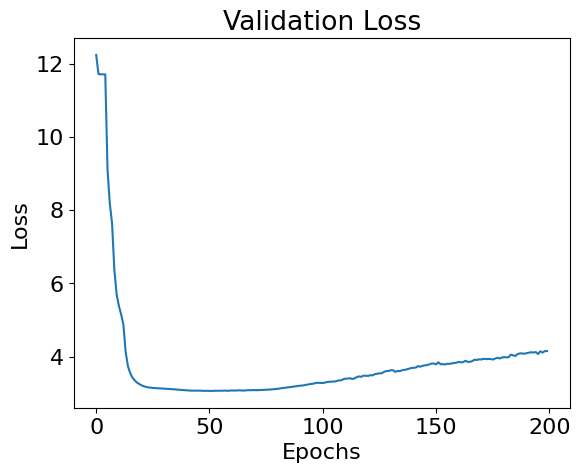

In [134]:
train_model(model, optimizer, criterion, train_loader, valid_loader, 200)

In [144]:
best_model =  LSTMModel_v1(input_size=input_LSTM, hidden_size=32, num_layers=layers, output_size=output_LSTM)
best_model.load_state_dict(torch.load('best_model_LSTM.pth'.format(input)))
predictions_n_to_n, actuals_n_to_n = test_model(best_model, test_loader, criterion)

Test Loss: 3.2736


In [145]:
result_prediction_by_month(predictions_n_to_n, actuals_n_to_n)


January
MAE: 0.81
MAPE: 0.21
RMSE: 1.18
MAAPE: 0.16

February
MAE: 0.86
MAPE: 0.28
RMSE: 1.18
MAAPE: 0.21

March
MAE: 0.84
MAPE: 0.23
RMSE: 1.17
MAAPE: 0.17

April
MAE: 0.83
MAPE: 0.32
RMSE: 1.17
MAAPE: 0.18

May
MAE: 0.93
MAPE: 0.28
RMSE: 1.30
MAAPE: 0.22

June
MAE: 0.98
MAPE: 0.34
RMSE: 1.43
MAAPE: 0.20

July
MAE: 1.04
MAPE: 0.24
RMSE: 1.53
MAAPE: 0.17

August
MAE: 1.02
MAPE: 0.33
RMSE: 1.53
MAAPE: 0.19


In [ ]:
#result_prediction(predictions, actuals)

##### f(a(t), b(t), c(t)) = a(t+1)

In [146]:
df_weekday_hour_prep.head(3)

station_id,42,60,70
time,,,
2013-08-29 12:00:00,6.458333,10.250000,1.395833
2013-08-29 13:00:00,6.754717,11.566038,3.094340
2013-08-29 14:00:00,7.250000,12.125000,4.625000


In [150]:
# Define the sliding window size and stride
window_size = 7
stride = 1

# Create datasets and data loaders for training, validation, and test sets
train_dataset = TimeSeriesDataset(train_data.values, window_size, stride, drop=[1, 2])
valid_dataset = TimeSeriesDataset(valid_data.values, window_size, stride, drop=[1, 2])
test_dataset = TimeSeriesDataset(test_data.values, window_size, stride, drop=[1, 2])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [151]:
# Parameters of the LSTM
layers = 3
hidden_size = 32
input_LSTM = 3
output_LSTM = 1

# Instantiate your LSTM model and define the loss function and optimizer
model = LSTMModel_v1(input_size=input_LSTM, hidden_size=hidden_size, num_layers=layers, output_size=output_LSTM)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Epoch 1/100, Training Loss: 361.2364, Validation Loss: 1.1356
Epoch 2/100, Training Loss: 361.3235, Validation Loss: 1.1409
Epoch 3/100, Training Loss: 360.3275, Validation Loss: 1.1627
Epoch 4/100, Training Loss: 359.4821, Validation Loss: 1.1472
Epoch 5/100, Training Loss: 358.3584, Validation Loss: 1.1479
Epoch 6/100, Training Loss: 357.3374, Validation Loss: 1.1494
Epoch 7/100, Training Loss: 356.3252, Validation Loss: 1.1531
Epoch 8/100, Training Loss: 355.2945, Validation Loss: 1.1585
Epoch 9/100, Training Loss: 354.2159, Validation Loss: 1.1650
Epoch 10/100, Training Loss: 353.1486, Validation Loss: 1.1727
Epoch 11/100, Training Loss: 352.0666, Validation Loss: 1.1789
Epoch 12/100, Training Loss: 351.0446, Validation Loss: 1.1855
Epoch 13/100, Training Loss: 350.1540, Validation Loss: 1.1878
Epoch 14/100, Training Loss: 349.2385, Validation Loss: 1.1925
Epoch 15/100, Training Loss: 348.3009, Validation Loss: 1.1945
Epoch 16/100, Training Loss: 347.4534, Validation Loss: 1.1979
E

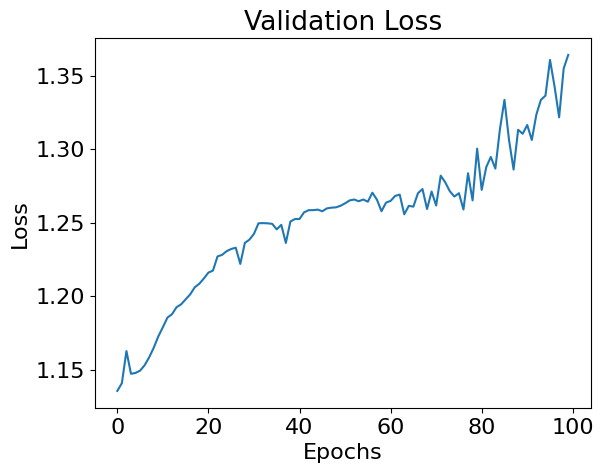

In [153]:
train_model(model, optimizer, criterion, train_loader, valid_loader, 100)

In [154]:
best_model =  LSTMModel_v1(input_size=input_LSTM, hidden_size=32, num_layers=layers, output_size=output_LSTM)
best_model.load_state_dict(torch.load('best_model_LSTM.pth'.format(input)))
predictions, actuals = test_model(best_model, test_loader, criterion)

Test Loss: 1.6803


In [155]:
result_prediction_by_month(predictions, actuals)


January
MAE: 0.70
MAPE: 0.17
RMSE: 1.10
MAAPE: 0.14

February
MAE: 0.71
MAPE: 0.22
RMSE: 1.11
MAAPE: 0.16

March
MAE: 0.74
MAPE: 0.20
RMSE: 1.11
MAAPE: 0.15

April
MAE: 0.79
MAPE: 0.29
RMSE: 1.19
MAAPE: 0.17

May
MAE: 0.84
MAPE: 0.24
RMSE: 1.27
MAAPE: 0.19

June
MAE: 0.94
MAPE: 0.31
RMSE: 1.42
MAAPE: 0.19

July
MAE: 0.95
MAPE: 0.22
RMSE: 1.47
MAAPE: 0.15

August
MAE: 0.97
MAPE: 0.28
RMSE: 1.53
MAAPE: 0.18


In [ ]:
#result_prediction(predictions, actuals)